# Feature Engineering

This notebook is a natural continuation of the exploratory data analysis in the Exploratory_Data_Analysis notebook.

Key findings from the EDA were:
- Missing values are relatively frequent, so a solution for nulls should be considered
- The two cities that the measurements are taken from have:
    - Different (hard to measure how different without more data..) climates according to the weather data
    - Have different train and test time measurement periods. And the test period immediately follows the training period for each city
        - This means the problem can be considered as a forecasting one, for each city. 
        - Initial feelings are that the model should condition for each city.
        
- Quarterly seasonality of total cases
- Strong autocorrelation of cases (previous weeks' case rate will be good predictor of the future)
            
- A quick peek of raw feature predictive power suggest that weekofyear, humidity, rain and temperature could be important in the model.

The purpose of this notebook will be to engineer features from the raw data to use in the final model. This will be a combination of:
- Intuition (e.g. time/seasonal related feature construction)
- Using SKLearn to explore features derived from PCA, polynomial, 'fromModel' and 'KBest' approaches.
- Use SKLearn to build a tunable feauture construction pipeline, with normalising, scaling and adding of other features.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context('talk')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
cwd = os.getcwd().split('\\')
local_repo_path = '\\'.join(cwd[:-1])
raw_data_path = local_repo_path + r'\data\raw'
processed_data_path = local_repo_path + '\data\processed'
feature_path = local_repo_path + r'\\data\\features'

In [3]:
train = pd.read_csv(processed_data_path + r'\train_dataset.csv', index_col = 0)
test = pd.read_csv(raw_data_path + r'\dengue_features_test.csv', index_col = None)
combined = pd.read_csv(processed_data_path + r'\combined_train_test_dataset.csv', index_col = 0)

## Add quarter to features

In [4]:
train['quarter'] = pd.to_datetime(train['week_start_date']).map(lambda x: x.quarter)
test['quarter'] = pd.to_datetime(test['week_start_date']).map(lambda x: x.quarter)

In [5]:
train_sj = train[train['city'] == 'sj']
test_sj = test[test['city']=='sj']
train_iq = train[train['city'] == 'iq'].reset_index()
test_iq = test[test['city'] == 'iq'].reset_index()

# Closer look at seasonal patterns

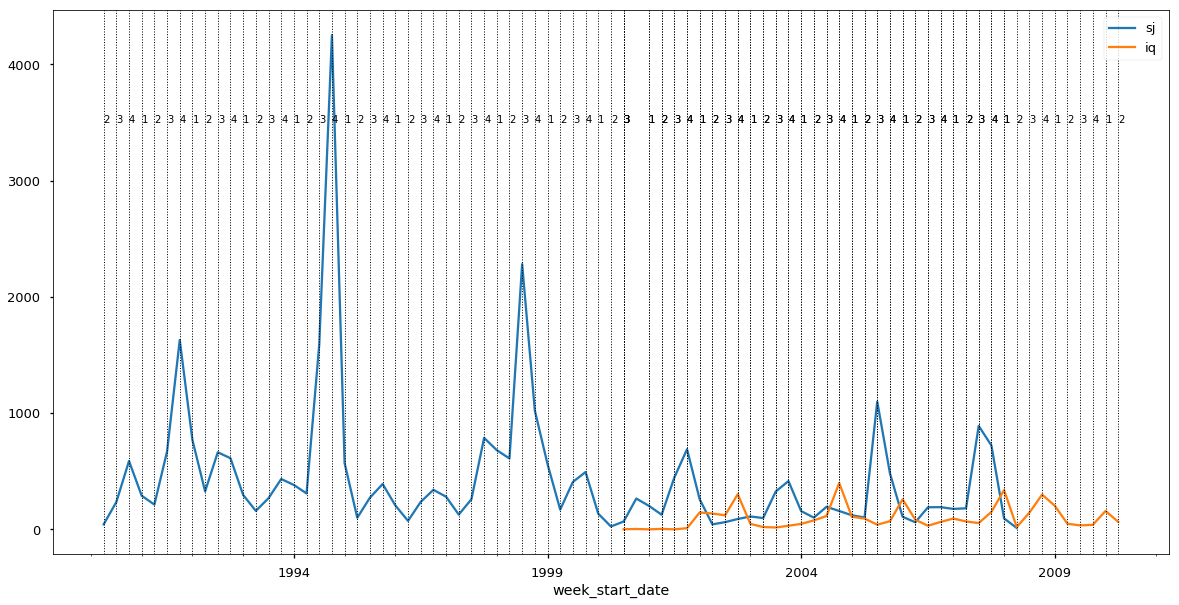

In [6]:
fig, ax = plt.subplots(figsize = (20,10))
train[train['city'] == 'sj'][['week_start_date', 'total_cases']].set_index(pd.DatetimeIndex(train[train['city'] == 'sj']['week_start_date'])).groupby(pd.Grouper(freq='Q')).sum().plot(ax = ax)
train[train['city'] == 'iq'][['week_start_date', 'total_cases']].set_index(pd.DatetimeIndex(train[train['city'] == 'iq']['week_start_date'])).groupby(pd.Grouper(freq='Q')).sum().plot(ax = ax)
ax.legend(labels = ['sj', 'iq'])
for i, d in enumerate(train['weekofyear']):
    if np.mod(d,13) == 0 or d == 53:
        ax.axvline(train['week_start_date'].values[i], color = 'black', linewidth = 1, linestyle = 'dotted')
        ax.text(train['week_start_date'].values[i], 3500, train['quarter'][i])

# Time related features

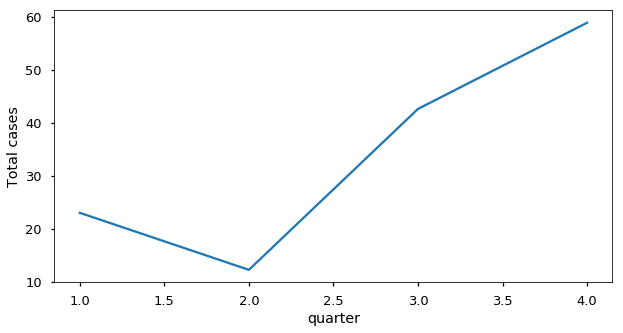

In [7]:
fig, ax = plt.subplots(figsize = (10,5))
train_sj[['quarter', 'total_cases']].groupby('quarter').agg(['mean']).plot(ax = ax)
ax.set_ylabel('Total cases')
ax.legend().set_visible(False)

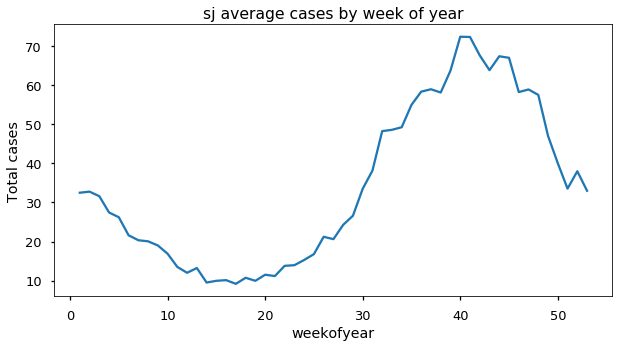

In [8]:
fig, ax = plt.subplots(figsize = (10,5));
train_sj[['weekofyear', 'total_cases']].groupby('weekofyear').agg(['mean']).plot(ax = ax);
ax.set_ylabel('Total cases');
ax.legend().set_visible(False);
ax.set_title('sj average cases by week of year');

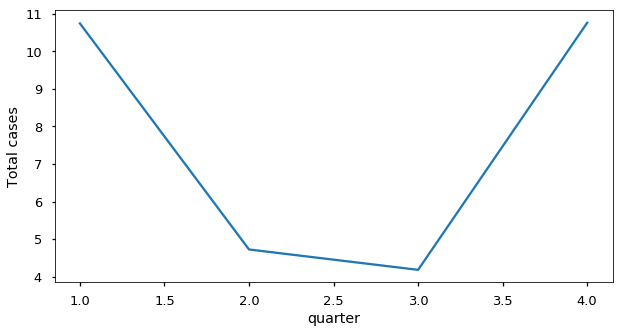

In [9]:
fig, ax = plt.subplots(figsize = (10,5))
train_iq[['quarter', 'total_cases']].groupby('quarter').agg(['mean']).plot(ax = ax)
ax.set_ylabel('Total cases')
ax.legend().set_visible(False)

In [10]:
weekly_cases_sj = train_sj[['weekofyear', 'total_cases']].groupby('weekofyear').mean()
pfit6 = np.polyfit(weekly_cases_sj.index, weekly_cases_sj['total_cases'], deg = 6)
p6 = np.poly1d(pfit6)

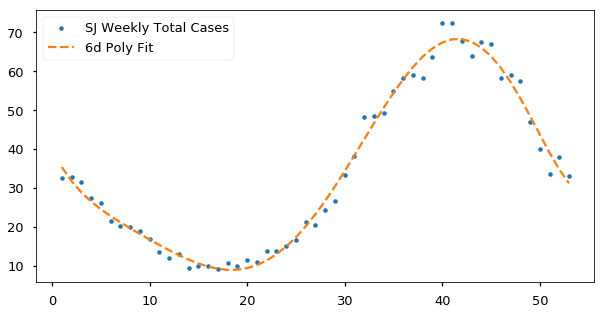

In [11]:
fig, ax = plt.subplots(figsize = (10,5));
ax.plot(weekly_cases_sj.index, weekly_cases_sj['total_cases'], '.', label = 'SJ Weekly Total Cases');
ax.plot(weekly_cases_sj.index, p6(weekly_cases_sj.index), '--', label = '6d Poly Fit');
ax.legend()

In [12]:
weekly_cases_iq = train_iq[['weekofyear', 'total_cases']].groupby('weekofyear').mean()
pfit2 = np.polyfit(weekly_cases_iq.index[:-2], weekly_cases_iq['total_cases'][:-2], deg = 2)
p2 = np.poly1d(pfit2)

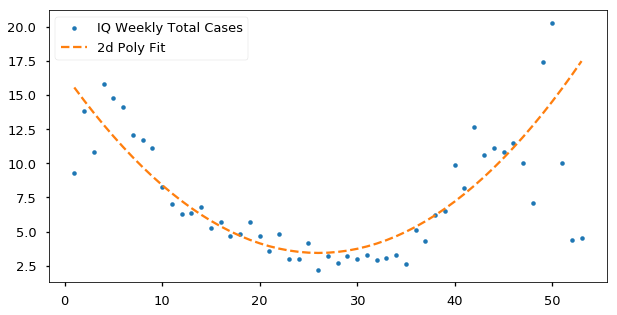

In [13]:
fig, ax = plt.subplots(figsize = (10,5));
ax.plot(weekly_cases_iq.index, weekly_cases_iq['total_cases'], '.', label = 'IQ Weekly Total Cases');
ax.plot(weekly_cases_iq.index, p2(weekly_cases_iq.index), '--', label = '2d Poly Fit');
ax.legend();

# Add polynomial fits as features..

In [14]:
sj_poly_train = p6(weekly_cases_sj.index)
iq_poly_train = p2(weekly_cases_iq.index)
sj_poly_test = p6(weekly_cases_sj.index)
iq_poly_test = p2(weekly_cases_iq.index)
train['poly_fit'] = 0
for i in (weekly_cases_sj.index):
    mask = (train.city == 'sj') & (train.weekofyear == i)
    train.loc[mask, 'poly_fit'] = sj_poly_train[i-1]
    mask = (test.city == 'sj') & (test.weekofyear == i)
    test.loc[mask, 'poly_fit'] = sj_poly_test[i-1]
    mask = (train.city == 'iq') & (train.weekofyear == i)
    train.loc[mask, 'poly_fit'] = iq_poly_train[i-1]
    mask = (test.city == 'iq') & (test.weekofyear == i)
    test.loc[mask, 'poly_fit'] = iq_poly_test[i-1]

In [15]:
train[['city','weekofyear','total_cases','poly_fit']].head()

,city,weekofyear,total_cases,poly_fit
0,sj,18,4,9.039287
1,sj,19,5,9.081744
2,sj,20,4,9.477176
3,sj,21,3,10.252293
4,sj,22,6,11.426181


# Pipeline construction with null imputation, scaling and PCA features

The weather data are highly correlated and on different scales. Let's look to replace these large number of features with a lower dimension of PCA constructed vectors.

In [16]:
from SKL_search import *
from sklearn.ensemble import RandomForestClassifier

In [17]:
numeric_cols = combined.select_dtypes(include=[np.number]).drop(['year', 'weekofyear'], axis = 1).columns
best_raw_features = ['reanalysis_dew_point_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_max_air_temp_k','reanalysis_specific_humidity_g_per_kg',
                    'station_min_temp_c', 'reanalysis_tdtr_k', 'station_avg_temp_c']

In [18]:
pre_process = Pipeline([("imputer", Imputer(strategy="mean")), ("scaler", RobustScaler())])
sj_prefit = pre_process.fit(train_sj[best_raw_features])
iq_prefit = pre_process.fit(train_iq[best_raw_features])

In [19]:
num_pca = 3
num_feature_pipeline = Pipeline([("imputer", Imputer(strategy="mean")), ("scaler", StandardScaler()),
                    ('features', 
                    FeatureUnion([('pca', PCAFeatureSelector(k = num_pca))]))])

In [20]:
sj_pipe_fit = num_feature_pipeline.fit(train_sj[numeric_cols], train_sj['total_cases'])
iq_pipe_fit = num_feature_pipeline.fit(train_iq[numeric_cols], train_iq['total_cases'])

In [21]:
X_sj = num_feature_pipeline.fit_transform(train_sj[numeric_cols], train_sj['total_cases'])
X_iq = X = num_feature_pipeline.fit_transform(train_iq[numeric_cols], train_iq['total_cases'])

In [22]:
X_sj_test = sj_pipe_fit.transform(test_sj[numeric_cols])
X_iq_test = iq_pipe_fit.transform(test_iq[numeric_cols])

# Feature sets construction

# Add month one hots

In [23]:
sj_feature_train = pd.DataFrame(X_sj, columns = ['PC1', 'PC2', 'PC3'])
sj_feature_train['weekofyear'] = train_sj['weekofyear']
sj_feature_train['poly_fit'] = train[train['city'] == 'sj']['poly_fit']
sj_feature_train['total_cases'] = train_sj['total_cases']
for f in best_raw_features:
    sj_feature_train[f] = pre_process.fit_transform(pd.DataFrame(train_sj[f]))

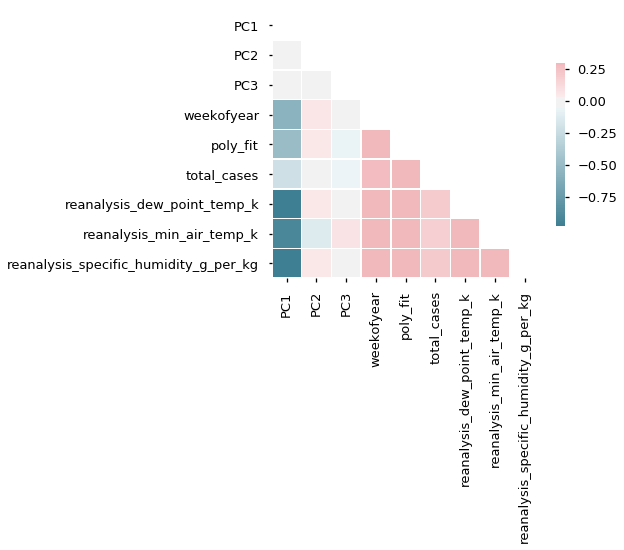

In [24]:
corr = sj_feature_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize = (6,6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data = corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

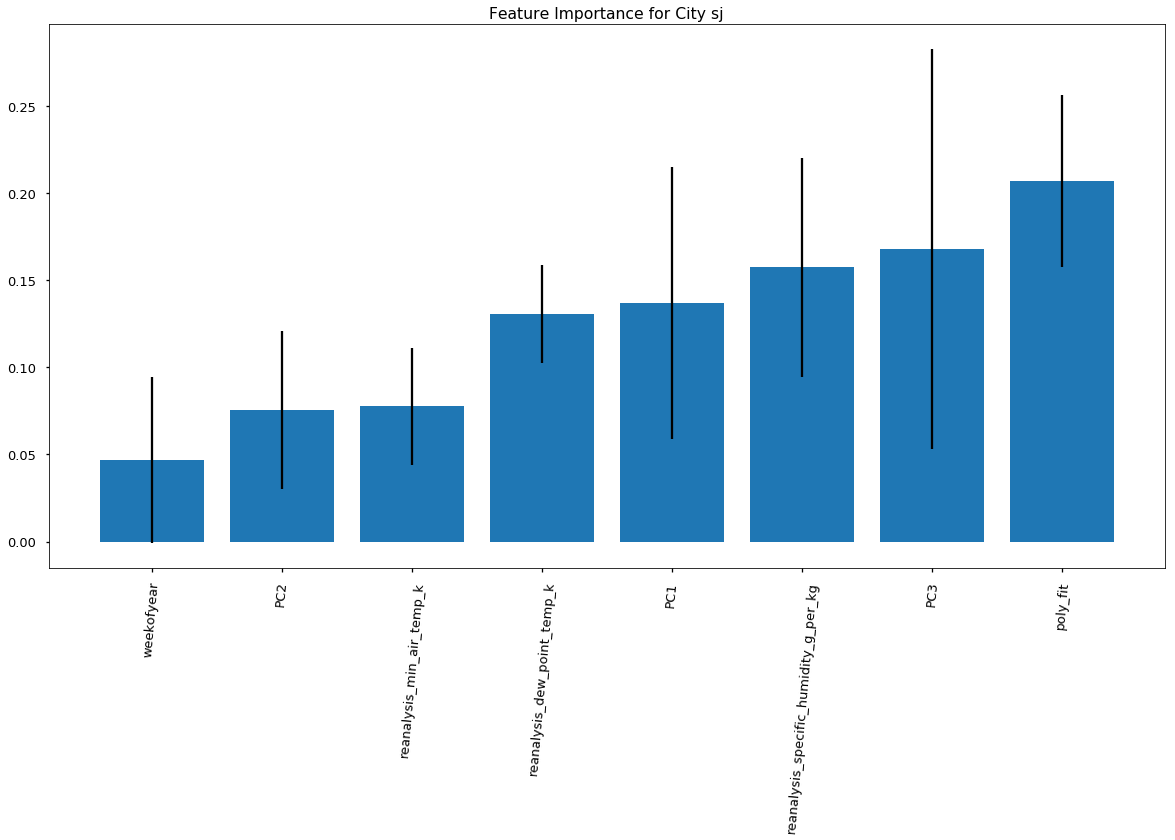

In [33]:
from sklearn.ensemble import RandomForestRegressor
mod = RandomForestRegressor()

X = sj_feature_train.drop(['total_cases'], axis = 1).dropna()
y = sj_feature_train.dropna()['total_cases']
mod.fit(X,y)

importance = mod.feature_importances_
importance = pd.DataFrame(importance, index=X.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_
                            for tree in mod.estimators_], axis=0)

importance = importance.sort_values(by = 'Importance')

x = range(importance.shape[0])
y = importance.ix[:, 0]
yerr = importance.ix[:, 1]

fig, ax = plt.subplots(figsize = (20,10));
plt.bar(x, y, yerr=yerr, align="center");
ax.set_xticks(np.arange(len(importance)));
ax.set_xticklabels(importance.index.tolist());
plt.xticks(rotation = 85);
plt.title('Feature Importance for City sj');

In [25]:
sj_feature_test = pd.DataFrame(X_sj_test, columns = ['PC1', 'PC2', 'PC3'])
sj_feature_test['weekofyear'] = test_sj['weekofyear']
sj_feature_test['poly_fit'] = test[test['city'] == 'sj']['poly_fit']
sj_feature_test['city'] = 'sj'
sj_feature_test['year'] = test[test['city'] == 'sj']['year']
for f in best_raw_features:
    sj_feature_test[f] = pre_process.fit_transform(pd.DataFrame(test_sj[f]))

In [26]:
train_iq = train_iq.reset_index()

In [27]:
iq_feature_train = pd.DataFrame(X_iq, columns = ['PC1', 'PC2', 'PC3'])
iq_feature_train['weekofyear'] = train_iq['weekofyear']
iq_feature_train['poly_fit'] = train[train['city'] == 'iq'].reset_index()['poly_fit']
iq_feature_train['total_cases'] = train_iq['total_cases']
for f in best_raw_features:
    iq_feature_train[f] = pre_process.fit_transform(pd.DataFrame(train_iq[f]))

In [28]:
test_iq = test_iq.reset_index()

In [29]:
iq_feature_test = pd.DataFrame(X_iq_test, columns = ['PC1', 'PC2', 'PC3'])
iq_feature_test['weekofyear'] = test_iq['weekofyear']
iq_feature_test['poly_fit'] = test[test['city'] == 'iq'].reset_index()['poly_fit']
iq_feature_test['city'] = 'iq'
iq_feature_test['year'] = test[test['city'] == 'iq'].reset_index()['year']
for f in best_raw_features:
    iq_feature_test[f] = pre_process.fit_transform(pd.DataFrame(test_iq[f]))

In [30]:
sj_feature_train.to_csv(feature_path + r'\\sj_train.csv')
sj_feature_test.to_csv(feature_path + r'\\sj_test.csv')
iq_feature_train.to_csv(feature_path + r'\\iq_train.csv')
iq_feature_test.to_csv(feature_path + r'\\iq_test.csv')